In [1]:
import numpy as np
from torch import tensor
from torch.nn import CrossEntropyLoss, MSELoss
from dataset.mnist import get_data as get_mnist
from qiskit.providers.fake_provider import (
    FakeVigo,
    FakeJakarta,
    FakeGuadalupe,
    FakeKolkata,
    FakeMumbai
)

# If you are not using the `qdna-lib` source code,
# comment out the following two lines.
import sys
sys.path.append('../../qdna-lib/')

from qdna.embedding import (
    AeFeatureMap,
)
from qdna.ansatz import (
    Qcnn,
    ConvSimple,
    PoolSimple
)

## Configuration

In [2]:
num_qubits = 4
feature_map_type = AeFeatureMap
conv_block_type = ConvSimple
pool_block_type = PoolSimple
noisy_device_type = None # FakeVigo, FakeJakarta, FakeGuadalupe, FakeKolkata, FakeMumbai, etc (None=ideal simulation)
get_dataset = get_mnist # get_mnist, get_fashion_mnist, get_cifar10 (see files in the folder 'dataset')
loss_func = CrossEntropyLoss() # MSELoss(), CrossEntropyLoss()
epochs = 10
batch_size = 8

num_measurements = int(np.ceil(np.log2(num_qubits)))
num_features = feature_map_type(num_qubits, reps=1).num_parameters_settable

In [3]:
print('num_measurements=', num_measurements)
print('num_features=', num_features)

num_measurements= 2
num_features= 16


## Dataset

In [4]:
from torch.utils.data import DataLoader
from sklearn.preprocessing import normalize

# labels must be in {0, 1}.
train_data, test_data = get_dataset(num_features)

In [5]:
# must normalize the data.
train_data.data = tensor(normalize(train_data.data))
test_data.data = tensor(normalize(test_data.data))

train_loader = DataLoader(list(zip(train_data.data, train_data.targets)), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(list(zip(test_data.data, test_data.targets)), batch_size=batch_size, shuffle=True)

## Device and sampler

In [6]:
from qiskit_aer import AerSimulator
from qiskit.primitives import BackendSampler

if noisy_device_type is None:
    # Local exact count simulation
    sampler = None
else:
    # Local noisy simulation
    noisy_backend = noisy_device_type()
    sampler = BackendSampler(backend = noisy_backend)

## Define and create QNNs

In [7]:
# Define and create QNNs
from qiskit import QuantumCircuit, ClassicalRegister
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN

algorithm_globals.random_seed = 12345

def null_interpret(x):
    # To define `output_shape` we must also define an `interpret` function,
    # even if it do nothing. If `output_shape` is not defined, the measurement
    # will always return an array with 2^n quasi-probabilities, padding with
    # zeroes the amplitudes not associated with measured qubits.
    return x

def place_measurements(qc):
    cbit = 0
    block_size = num_qubits
    while block_size > 1:
        qbit = num_qubits - block_size
        qc.measure(qbit, cbit)
        cbit += 1
        block_size = int(np.ceil(block_size / 2))

def create_qnn(traditional_qcnn=False):

    feature_map = feature_map_type(num_qubits, reps=1)
    ansatz = Qcnn(num_qubits, conv_block=conv_block_type(), pool_block=pool_block_type())

    qc = QuantumCircuit(num_qubits)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz.decompose(), inplace=True)

    if traditional_qcnn:
        qc.add_register(ClassicalRegister(1))
        qc.measure(num_qubits-2, 0)
        output_shape=2
    else:
        qc.add_register(ClassicalRegister(num_measurements))
        place_measurements(qc)
        output_shape=2**(num_measurements)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        sampler=sampler,
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
        interpret=null_interpret,
        output_shape=output_shape
    )

    return qnn

qnn_new = create_qnn()
qnn_traditional = create_qnn(traditional_qcnn=True)

## Define torch NN module

In [14]:
# Define torch NN module
from torch import concat, sum as tsum
from torch.nn import (
    Module,
    Linear,
    Sequential,
    CELU,
    Sigmoid
)
from qiskit_machine_learning.connectors import TorchConnector

def get_counts(x, num_measurements):
    # Calculates the probability of measuring zero on each qubit
    # separately from the measurement probability vector.

    size = 2**(num_measurements)

    idx = [v for i, v in enumerate(range(size)) if i % 2 < 1]
    new_x = tsum(x[:,idx], 1, True)

    for bit in range(1, num_measurements):
        idx = [v for i, v in enumerate(range(size)) if i % 2**(bit+1) < 2**bit]
        new_x = concat([new_x, tsum(x[:,idx], 1, True)], 1)

    return new_x

class Net(Module):
    def __init__(self, qnn, layers_sizes, traditional_qcnn=False):
        input_size, hidden_size, output_size = layers_sizes
        super().__init__()
        if not traditional_qcnn:
            self.linear_stack = Sequential(
                Linear(input_size, hidden_size),
                CELU(),
                Linear(hidden_size, hidden_size),
                CELU(),
                Linear(hidden_size, output_size),
                Sigmoid()
            )
        self.qnn = TorchConnector(qnn)
        self._traditional_qcnn = traditional_qcnn

    def forward(self, x):
        if self._traditional_qcnn:
            x = get_counts(self.qnn(x), num_measurements=1)
        else:
            x = get_counts(self.qnn(x), num_measurements=num_measurements)
            # x = x.float()  # Convert to float32 OR x.double()  # Convert to float64
            x = self.linear_stack(x)
        # Uncomment the line below to visually follow the convergence.
        # print(x.reshape(-1))
        return x.reshape(-1)

input_size = num_measurements
layers_sizes = (input_size, 3 * input_size, 1)


## Training

In [15]:
import torch.optim as optim
from torch import save

def training(model, train_loader):
    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    # Start training
    loss_list = [] # Store loss history
    model.train()  # Set model to training mode

    for epoch in range(epochs):
        total_loss = []
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.squeeze()
            target = target.float()

            optimizer.zero_grad(set_to_none=True) # Initialize gradient
            output = model(data)                  # Forward pass
            loss = loss_func(output, target)      # Calculate loss
            loss.backward()                       # Backward pass
            optimizer.step()                      # Optimize weights
            total_loss.append(loss.item())        # Store loss

        loss_list.append(sum(total_loss) / len(total_loss))
        print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

    return loss_list

def save_training_data(model, loss_list, file_suffix):
    save(model.state_dict(), f"./save/model_dict_{file_suffix}.pt")

    with open(f"./save/loss_list_{file_suffix}.txt",'w') as f:
        np.savetxt(f, loss_list, delimiter=",")

In [16]:
model_new = Net(qnn_new, layers_sizes)
model_new

Net(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=6, bias=True)
    (1): CELU(alpha=1.0)
    (2): Linear(in_features=6, out_features=6, bias=True)
    (3): CELU(alpha=1.0)
    (4): Linear(in_features=6, out_features=1, bias=True)
    (5): Sigmoid()
  )
  (qnn): TorchConnector()
)

### train new model

In [18]:
model_new = Net(qnn_new, layers_sizes)
loss_list_new = training(model_new, train_loader)

Training [10%]	Loss: 8.1806
Training [20%]	Loss: 7.5609
Training [30%]	Loss: 7.3099
Training [40%]	Loss: 7.2063
Training [50%]	Loss: 7.0326
Training [60%]	Loss: 7.0744
Training [70%]	Loss: 7.0926
Training [80%]	Loss: 7.0568
Training [90%]	Loss: 7.0036
Training [100%]	Loss: 6.9828


In [31]:
# Assuming 'data_loader' is your DataLoader instance
for data, target in train_loader:
    print(data.dtype)
    print(target.dtype)
    break

torch.float64
torch.float32


In [19]:
save_training_data(model_new, loss_list_new, 'new')

### train traditional model (comparison basis)

In [20]:
model_traditional = Net(qnn_traditional, layers_sizes, traditional_qcnn=True)
loss_list_traditional = training(model_traditional, train_loader)

Training [10%]	Loss: 8.1584
Training [20%]	Loss: 7.8624
Training [30%]	Loss: 7.7184
Training [40%]	Loss: 7.7133
Training [50%]	Loss: 7.7073
Training [60%]	Loss: 7.6927
Training [70%]	Loss: 7.6599
Training [80%]	Loss: 7.6360
Training [90%]	Loss: 7.6860
Training [100%]	Loss: 7.6158


In [21]:
save_training_data(model_traditional, loss_list_traditional, 'traditional')

## Plot training history

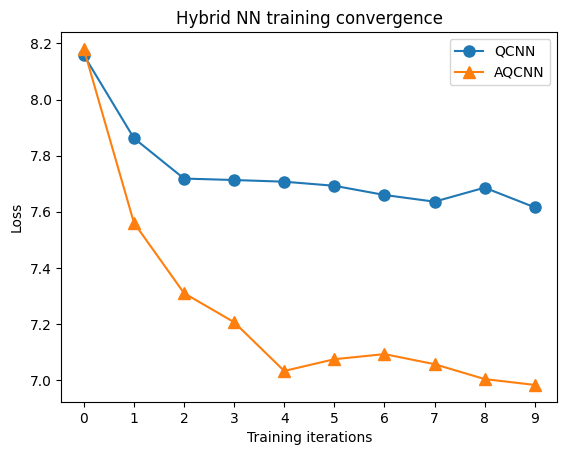

In [22]:
# Plot loss convergence
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rc

new_model_data = np.loadtxt(
    './save/loss_list_new.txt', delimiter=','
)

traditional_model_data = np.loadtxt(
    './save/loss_list_traditional.txt', delimiter=','
)

r = list(range(epochs))

# Data
df=pd.DataFrame(
    { 'x_values': r, 'QCNN': traditional_model_data,
      'AQCNN': new_model_data,      
    }
)

# multiple line plots
plt.plot( 'x_values', 'QCNN' , data=df, marker='o', markersize=8)
plt.plot( 'x_values', 'AQCNN' , data=df, marker='^', markersize=8)

plt.title("Hybrid NN training convergence")
plt.xlabel("Training iterations")
plt.ylabel("Loss")
plt.xticks(r)
plt.legend()
plt.show()

## Testing

In [23]:
from torch import load

model_new_2 = Net(qnn_new, layers_sizes)
model_new_2.load_state_dict(load("./save/model_dict_new.pt"))

model_traditional_2 = Net(qnn_traditional, layers_sizes, traditional_qcnn=True)
model_traditional_2.load_state_dict(load("./save/model_dict_traditional.pt"))

<All keys matched successfully>

In [24]:
def test_model(model, test_loader):
    from torch import no_grad
    
    #loss_func = CrossEntropyLoss()
    #loss_func = MSELoss()

    model.eval()  # set model to evaluation mode
    with no_grad():
        total_loss = []
        correct = 0
        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.squeeze()
            # target = tensor(target, dtype=float32)
            target = target.float()

            output = model(data)

            pred = np.round(output, 0)
            # # Uncomment the line below to visually follow the test.
            # print('pred', pred)
            # print('target', target)

            correct += pred.eq(target.view_as(pred)).sum().item()

            loss = loss_func(output, target)
            total_loss.append(loss.item())

        print(
            "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
                sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
            )
        )

In [25]:
test_model(model_new_2, test_loader)

Performance on test data:
	Loss: 7.0114
	Accuracy: 99.6%


In [26]:
test_model(model_traditional_2, test_loader)

Performance on test data:
	Loss: 7.6081
	Accuracy: 96.9%


### Plot a couple of tests

In [27]:
def plot_test_model(model, test_loader):
    # Plot predicted labels
    from torch import no_grad
    import matplotlib.pyplot as plt

    n_samples_show = 6
    count = 0
    fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

    model.eval()
    with no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data = data.squeeze()
            target = target.float()
            if count == n_samples_show:
                break
            output = model(data)
            
            pred = np.round([output[0]], 0)

            axes[count].imshow(
                data[0].numpy().reshape(
                    len(data[0])//int(np.floor(np.sqrt(len(data[0])))),
                    int(np.floor(np.sqrt(len(data[0]))))
                ),
                cmap="gray"
            )

            axes[count].set_xticks([])
            axes[count].set_yticks([])
            axes[count].set_title("Tgt {} Pred {}".format(int(target[0]), int(pred.item())))

            count += 1

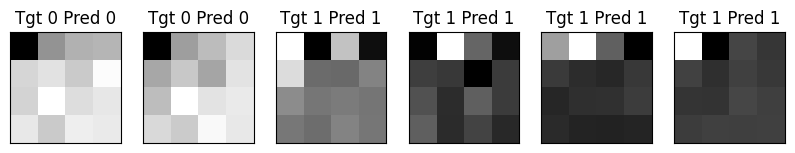

In [28]:
plot_test_model(model_new_2, test_loader)

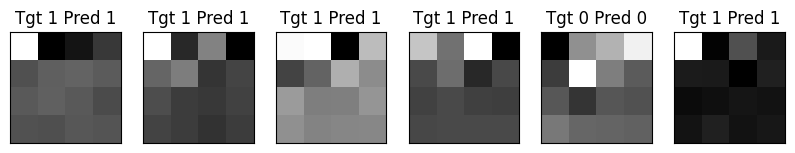

In [29]:
plot_test_model(model_traditional_2, test_loader)